### This notebook is used to generate visualisation of images in this hives

In [4]:
# Bunch of imports
import numpy as np
import sys,os,cv2
from datetime import datetime, timezone
import matplotlib.pyplot as plt
sys.path.append('Preprocessing')
sys.path.append('ForegroundRemoval/MedianFilter')
sys.path.append('ForegroundRemoval/PercentileFilter')
sys.path.append('VideoManagment')
from preproc import beautify_frame
from videolib import imageHiveOverview

ModuleNotFoundError: No module named 'matplotlib'

## Configuration

In [ ]:
# Get the latest picture of the hive specified. Last common picture taken by all cameras
hive = 1
data_folder = "/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/24.11-24.12_actuation_OH/Images/"

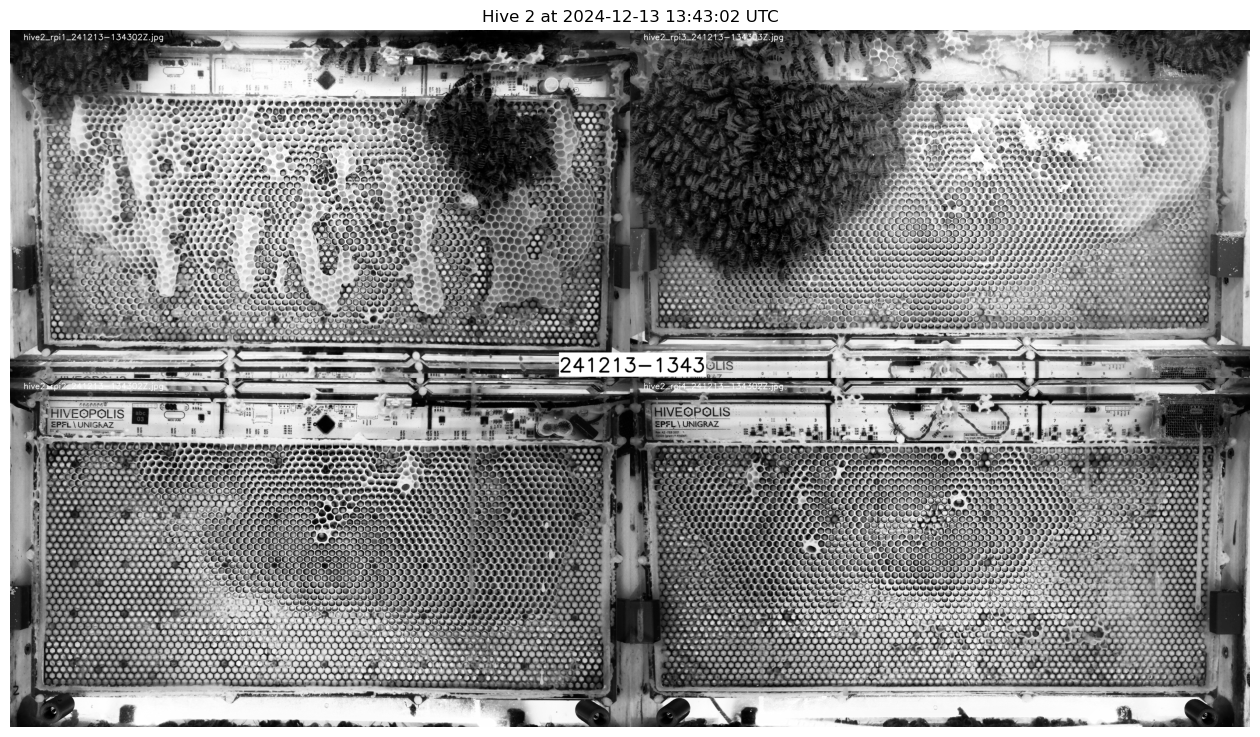

In [ ]:
# Within the subfolders, find those that have the hive number
subfolders = [f for f in os.listdir(data_folder) if "h"+str(hive)+"r" in f]
subfolders.sort()

# Within those subfolders, find the last image taken commom to all cameras based on filename
# Initialize a dictionary to store the latest image time for each subfolder
latest_images = {}

for subfolder in subfolders:
    images = [f for f in os.listdir(data_folder + subfolder) if f.endswith('.jpg')]
    for image in images:
        image_time = str(image.split('_')[-1].split('.')[0])
        naive_dt = datetime.strptime(image_time, "%y%m%d-%H%M%SZ")
        aware_dt = naive_dt.replace(tzinfo=timezone.utc)
        if subfolder not in latest_images or aware_dt.timestamp() > latest_images[subfolder].timestamp():
            latest_images[subfolder] = aware_dt

# Find the latest common image time
latest_common_time = min(latest_images.values())

latest_images = [None for i in range(len(subfolders))]
# Find the corresponding image name in one of the subfolders
for i,subfolder in enumerate(subfolders):
    images = [f for f in os.listdir(data_folder + subfolder) if f.endswith('.jpg')]
    for image in images:
        image_time = str(image.split('_')[-1].split('.')[0])
        naive_dt = datetime.strptime(image_time, "%y%m%d-%H%M%SZ")
        aware_dt = naive_dt.replace(tzinfo=timezone.utc)
        if aware_dt.replace(second=0, microsecond=0) == latest_common_time.replace(second=0, microsecond=0): # We only compare up to the minute
            latest_images[i] = image
            break

# Load the latest images with CV2 in grayscale
images = [cv2.imread(data_folder + subfolders[i] + '/' + latest_images[i], cv2.IMREAD_GRAYSCALE) for i in range(len(subfolders))]
# Apply the preprocessing
images = [beautify_frame(image) for image in images]
# Display the images
composed_img = imageHiveOverview(images, latest_images)
plt.figure(figsize=(16,12))
plt.imshow(composed_img, cmap='gray')
plt.axis('off')
plt.title("Hive " + str(hive) + " at " + latest_common_time.strftime("%Y-%m-%d %H:%M:%S") + " UTC")
plt.show()